In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36267 Dashboard: /proxy/36669/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_nostress_total.db'
session = cc.database.create_session(db)
expt = ['025deg_jra55_ryf_nostress_cont','025deg_jra55_ryf_nostress']
names = {'025deg_jra55_ryf_nostress_cont':'Control','025deg_jra55_ryf_nostress':'No Stress'}

### 1. Barotropic Streamfunction

In [5]:
x_min = -100
x_max = 10
y_min = 20
y_max = 65
tx_trans_int_z_con = cc.querying.getvar(expt[0],'tx_trans_int_z',session,start_time='1900-01-01',
                       end_time = '1950-12-31')#.sel(xu_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))
ty_trans_int_z_con = cc.querying.getvar(expt[0],'ty_trans_int_z',session,start_time='1900-01-01',
                       end_time = '1950-12-31')#.sel(xt_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))
tx_trans_int_z_buo = cc.querying.getvar(expt[1],'tx_trans_int_z',session,start_time='1900-01-01',
                       end_time = '1950-12-31')#.sel(xu_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))
ty_trans_int_z_buo = cc.querying.getvar(expt[1],'ty_trans_int_z',session,start_time='1900-01-01',
                       end_time = '1950-12-31')#.sel(xt_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))

In [6]:
xt_ocean = cc.querying.getvar(expt=expt[0], variable='xt_ocean', session=session, frequency='static', n=1)
yu_ocean = cc.querying.getvar(expt=expt[0], variable='yu_ocean', session=session, frequency='static', n=1)
time = ty_trans_int_z_buo.time

In [23]:
temp1 = ty_trans_int_z_con.values - tx_trans_int_z_con.values
temp2 = ty_trans_int_z_buo.values - tx_trans_int_z_buo.values
ty_trans_final_con = xr.DataArray(temp1, coords=[time,yu_ocean,xt_ocean], dims=['time','yu_ocean','xt_ocean'])
ty_trans_final_buo = xr.DataArray(temp2, coords=[time,yu_ocean,xt_ocean], dims=['time','yu_ocean','xt_ocean'])

In [ ]:
ty_con = ty_trans_final_con.sel(xt_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))
psi_con_final = ty_con.cumsum('xt_ocean').where(abs(ty_con<=1.e20))/(rho0*1.e6)

ty_buo = ty_trans_final_buo.sel(xt_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))
psi_buo_final = ty_buo.cumsum('xt_ocean').where(abs(ty_buo<=1.e20))/(rho0*1.e6)

In [56]:
vars_025deg = cc.querying.get_variables(session, experiment=expt[0])
vars_025deg[vars_025deg['name'].str.lower().str.match('time')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
2,Time,Time,None,restart017/ocean/ocean_neutral.res.nc,204,None,None
106,time,None,None,restart015/ice/i2o.nc,103,None,None
180,time,time,1 daily,output026/ocean/ocean-2d-sea_level-1-daily-mea...,12974,1900-01-01 00:00:00,1954-01-01 00:00:00
181,time_bounds,time axis boundaries,1 daily,output026/ocean/ocean-2d-sea_level-1-daily-mea...,12920,1900-01-01 00:00:00,1954-01-01 00:00:00
366,time,time,1 monthly,output026/ocean/ocean-3d-ty_trans_rho_gm-1-mon...,4444,1900-01-01 00:00:00,1954-01-01 00:00:00
367,time_bounds,time axis boundaries,1 monthly,output026/ocean/ocean-3d-ty_trans_rho_gm-1-mon...,4444,1900-01-01 00:00:00,1954-01-01 00:00:00
410,time,time,static,output026/ocean/ocean-2d-drag_coeff.nc,405,1900-01-01 00:00:00,1954-01-01 00:00:00


Text(0.5, 1.0, 'North Atlantic Gyre for no stress run - 1945')

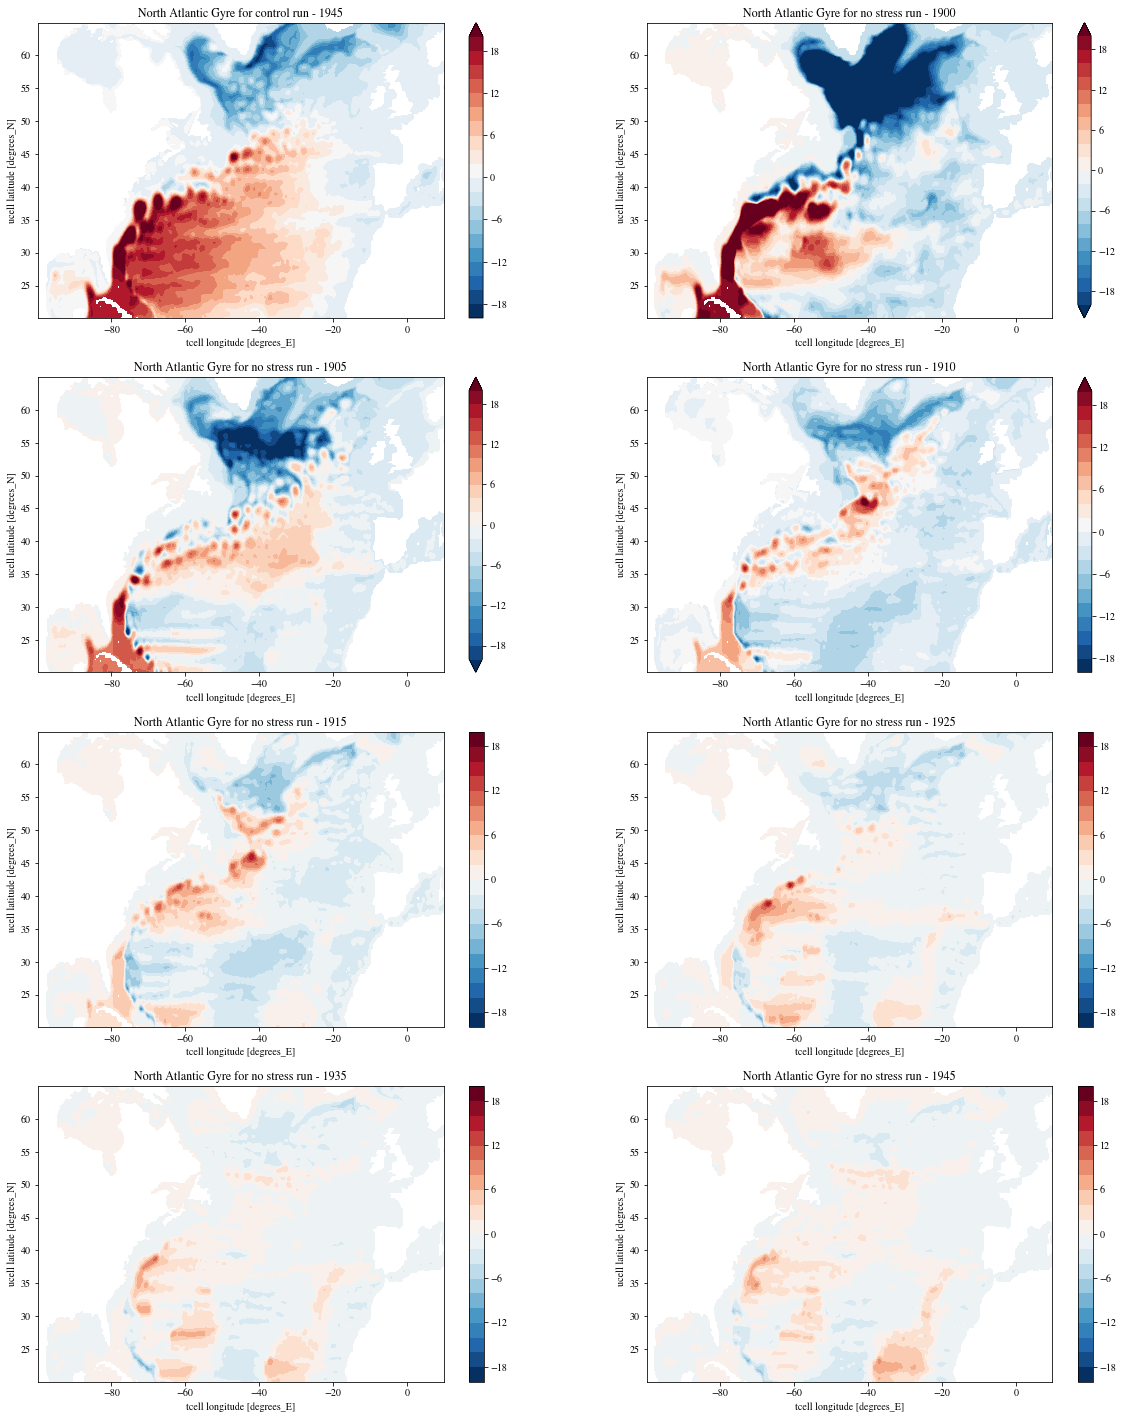

In [36]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(20,25))

psi_con_final.sel(time = slice('1945-01-01','1945-12-31')).mean('time').plot.contourf(ax = axes[0][0],levels = np.linspace(-20,20,21))
axes[0][0].set_title('North Atlantic Gyre for control run - 1945')

psi_buo_final.sel(time = slice('1900-01-01','1900-12-31')).mean('time').plot.contourf(ax = axes[0][1],levels = np.linspace(-20,20,21))
axes[0][1].set_title('North Atlantic Gyre for no stress run - 1900')

psi_buo_final.sel(time = slice('1905-01-01','1905-12-31')).mean('time').plot.contourf(ax = axes[1][0],levels = np.linspace(-20,20,21))
axes[1][0].set_title('North Atlantic Gyre for no stress run - 1905')

psi_buo_final.sel(time = slice('1910-01-01','1910-12-31')).mean('time').plot.contourf(ax = axes[1][1],levels = np.linspace(-20,20,21))
axes[1][1].set_title('North Atlantic Gyre for no stress run - 1910')

psi_buo_final.sel(time = slice('1915-01-01','1915-12-31')).mean('time').plot.contourf(ax = axes[2][0],levels = np.linspace(-20,20,21))
axes[2][0].set_title('North Atlantic Gyre for no stress run - 1915')

psi_buo_final.sel(time = slice('1925-01-01','1925-12-31')).mean('time').plot.contourf(ax = axes[2][1],levels = np.linspace(-20,20,21))
axes[2][1].set_title('North Atlantic Gyre for no stress run - 1925')

psi_buo_final.sel(time = slice('1935-01-01','1935-12-31')).mean('time').plot.contourf(ax = axes[3][0],levels = np.linspace(-20,20,21))
axes[3][0].set_title('North Atlantic Gyre for no stress run - 1935')

psi_buo_final.sel(time = slice('1945-01-01','1945-12-31')).mean('time').plot.contourf(ax = axes[3][1],levels = np.linspace(-20,20,21))
axes[3][1].set_title('North Atlantic Gyre for no stress run - 1945')

### 2. Velocity Shear

In [46]:
u_con = cc.querying.getvar(expt[0],'u',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1950-12-31').sel(xu_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))
v_con = cc.querying.getvar(expt[0],'v',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1950-12-31').sel(xu_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))
u_buo = cc.querying.getvar(expt[1],'u',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1950-12-31').sel(xu_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))
v_buo = cc.querying.getvar(expt[1],'v',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1950-12-31').sel(xu_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))

In [47]:
ushear_con = u_con.sel(time = slice('1901-01-01','1950-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
ushear_buo = u_buo.sel(time = slice('1901-01-01','1950-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
vshear_con = v_con.sel(time = slice('1901-01-01','1950-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
vshear_buo = v_buo.sel(time = slice('1901-01-01','1950-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')

Text(0.5, 1.0, 'Velocity Shear - Year 1901')

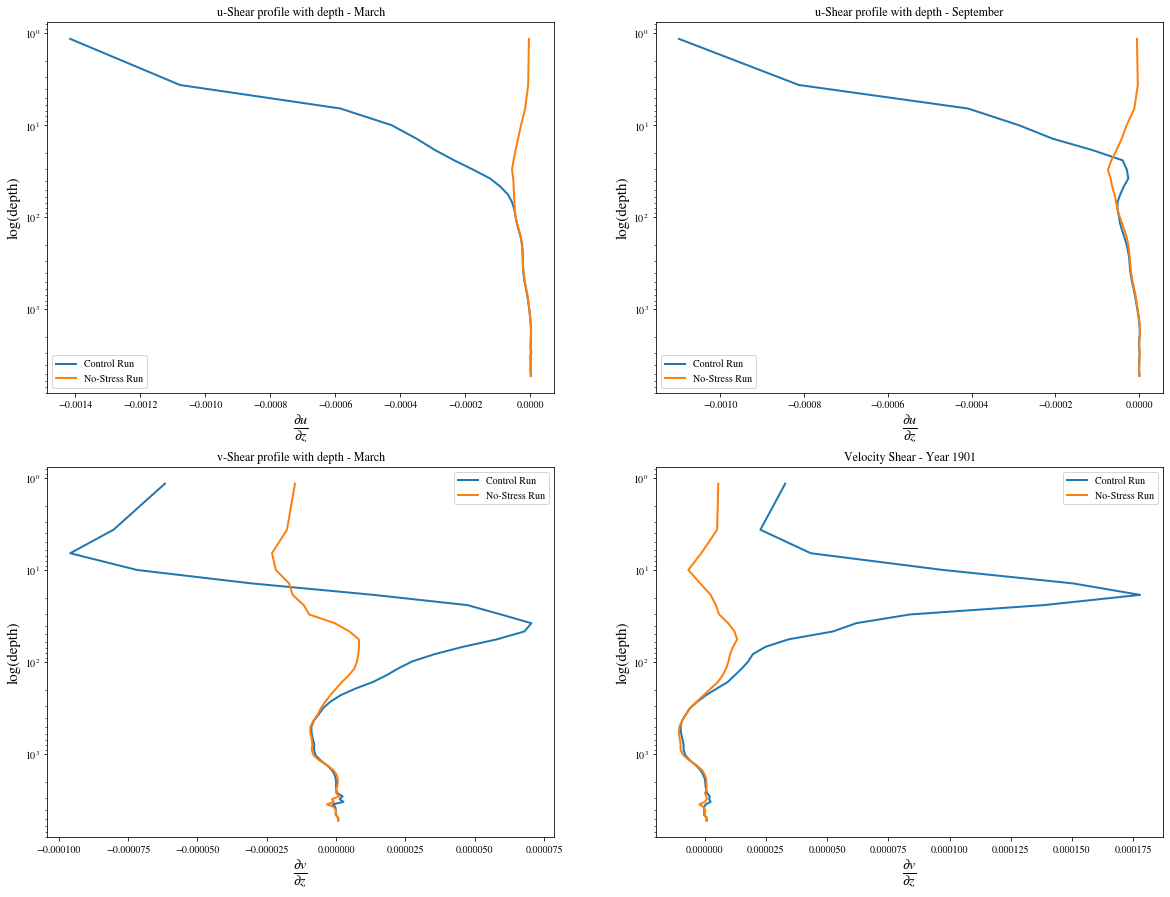

In [48]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

#plt.gca().invert_yaxis()
axes[0][0].invert_yaxis()
axes[0][0].set_yscale("log")
ushear_con.sel(time = slice('1901-03-01','1901-03-31')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='Control Run')
ushear_buo.sel(time = slice('1901-03-01','1901-03-31')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='No-Stress Run')
axes[0][0].set_xlabel(r'$\frac{\partial u}{\partial z}$',fontsize = 20)
axes[0][0].set_ylabel('log(depth)',fontsize = 15)
axes[0][0].set_title('u-Shear profile with depth - March')
axes[0][0].legend()

axes[0][1].invert_yaxis()
axes[0][1].set_yscale("log")
ushear_con.sel(time = slice('1901-09-01','1901-09-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='Control Run')
ushear_buo.sel(time = slice('1901-09-01','1901-09-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='No-Stress Run')
axes[0][1].set_xlabel(r'$\frac{\partial u}{\partial z}$',fontsize = 20)
axes[0][1].set_ylabel('log(depth)',fontsize = 15)
axes[0][1].set_title('u-Shear profile with depth - September')
axes[0][1].legend()

axes[1][0].invert_yaxis()
axes[1][0].set_yscale("log")
vshear_con.sel(time = slice('1901-03-01','1901-03-31')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='Control Run')
vshear_buo.sel(time = slice('1901-03-01','1901-03-31')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='No-Stress Run')
axes[1][0].set_xlabel(r'$\frac{\partial v}{\partial z}$',fontsize = 20)
axes[1][0].set_ylabel('log(depth)',fontsize = 15)
axes[1][0].set_title('v-Shear profile with depth - March')
axes[1][0].legend()

axes[1][1].invert_yaxis()
axes[1][1].set_yscale("log")
vshear_con.sel(time = slice('1901-09-01','1901-09-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='Control Run')
vshear_buo.sel(time = slice('1901-09-01','1901-09-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='No-Stress Run')
axes[1][1].set_xlabel(r'$\frac{\partial v}{\partial z}$',fontsize = 20)
axes[1][1].set_ylabel('log(depth)',fontsize = 15)
axes[1][1].set_title('v-Shear profile with depth - September')
axes[1][1].legend()

plt.title('Velocity Shear - Year 1901')

Text(0.5, 1.0, 'Velocity Shear - Year 1950')

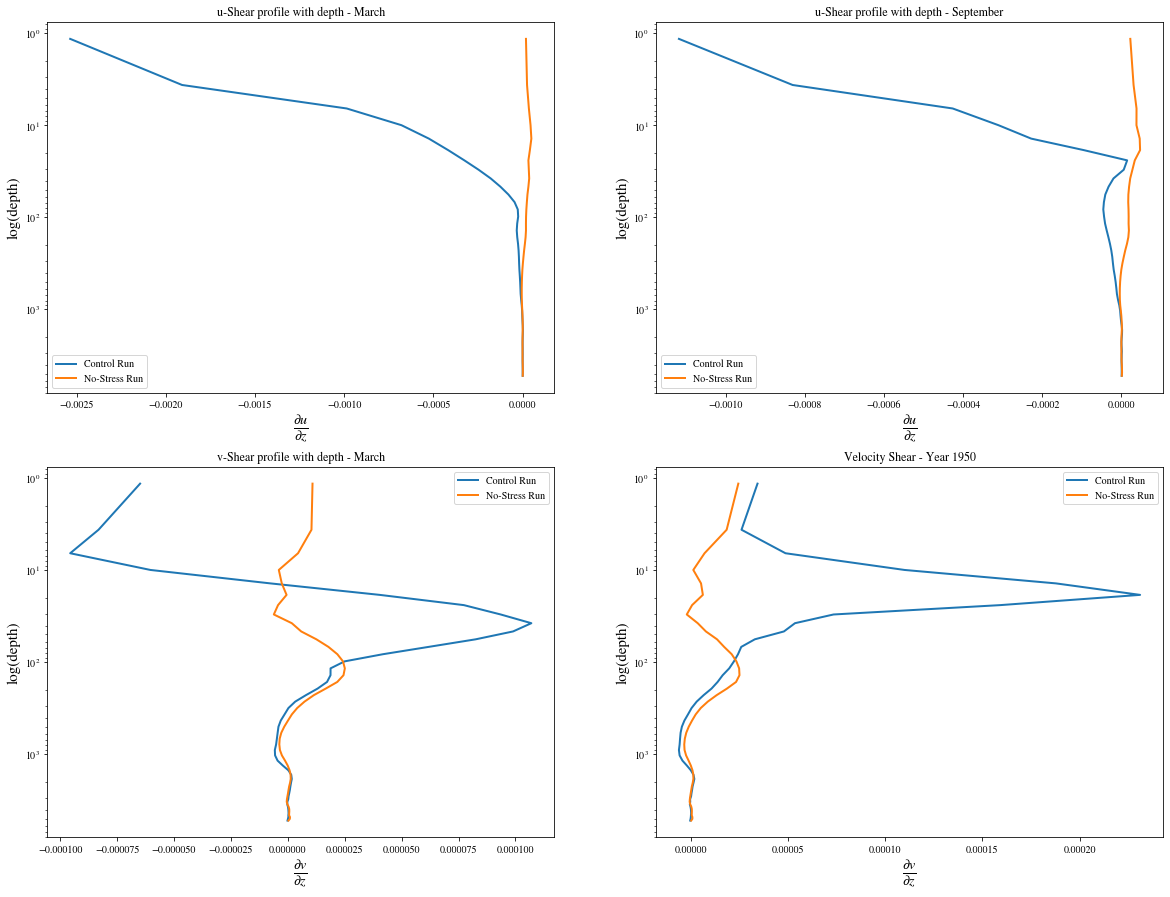

In [51]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

#plt.gca().invert_yaxis()
axes[0][0].invert_yaxis()
axes[0][0].set_yscale("log")
ushear_con.sel(time = slice('1950-01-03','1950-03-31')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='Control Run')
ushear_buo.sel(time = slice('1950-01-03','1950-03-31')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='No-Stress Run')
axes[0][0].set_xlabel(r'$\frac{\partial u}{\partial z}$',fontsize = 20)
axes[0][0].set_ylabel('log(depth)',fontsize = 15)
axes[0][0].set_title('u-Shear profile with depth - March')
axes[0][0].legend()

axes[0][1].invert_yaxis()
axes[0][1].set_yscale("log")
ushear_con.sel(time = slice('1950-09-01','1950-09-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='Control Run')
ushear_buo.sel(time = slice('1950-09-01','1950-09-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='No-Stress Run')
axes[0][1].set_xlabel(r'$\frac{\partial u}{\partial z}$',fontsize = 20)
axes[0][1].set_ylabel('log(depth)',fontsize = 15)
axes[0][1].set_title('u-Shear profile with depth - September')
axes[0][1].legend()

axes[1][0].invert_yaxis()
axes[1][0].set_yscale("log")
vshear_con.sel(time = slice('1950-03-01','1950-03-31')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='Control Run')
vshear_buo.sel(time = slice('1950-03-01','1950-03-31')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='No-Stress Run')
axes[1][0].set_xlabel(r'$\frac{\partial v}{\partial z}$',fontsize = 20)
axes[1][0].set_ylabel('log(depth)',fontsize = 15)
axes[1][0].set_title('v-Shear profile with depth - March')
axes[1][0].legend()

axes[1][1].invert_yaxis()
axes[1][1].set_yscale("log")
vshear_con.sel(time = slice('1950-09-01','1950-09-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='Control Run')
vshear_buo.sel(time = slice('1950-09-01','1950-09-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='No-Stress Run')
axes[1][1].set_xlabel(r'$\frac{\partial v}{\partial z}$',fontsize = 20)
axes[1][1].set_ylabel('log(depth)',fontsize = 15)
axes[1][1].set_title('v-Shear profile with depth - September')
axes[1][1].legend()

plt.title('Velocity Shear - Year 1950')

### 3. Heat fluxes

In [52]:
Qnet_con = cc.querying.getvar(expt=expt[0], variable='net_sfc_heating', session=session, frequency='1 monthly', start_time='1900-01-01', end_time='1950-12-31').sel(
    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))
Qnet_buo = cc.querying.getvar(expt=expt[1], variable='net_sfc_heating', session=session, frequency='1 monthly', start_time='1900-01-01', end_time='1950-12-31').sel(
    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))
area_t = cc.querying.getvar(expt=expt[0], variable='area_t', session=session, frequency='static', n=1).sel(
    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))

In [54]:
Qnet_avg_con = (Qnet_con*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])
Qnet_avg_buo = (Qnet_buo*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])

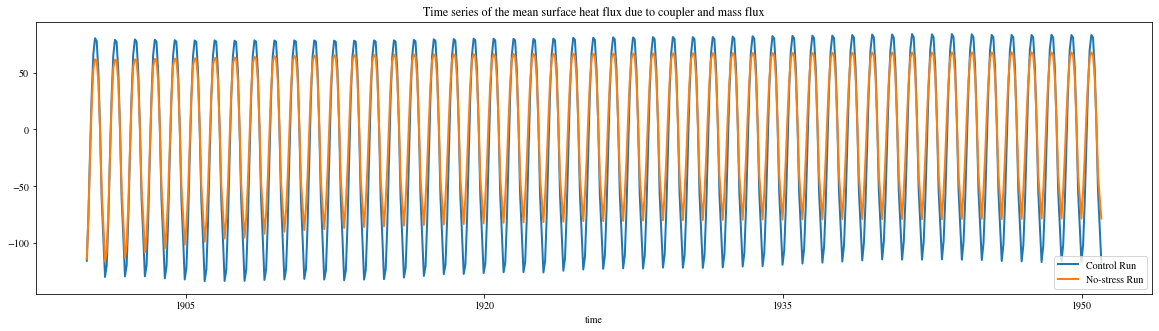

In [55]:
plt.figure(figsize=(20,5))
plt.subplot(111)
Qnet_avg_con.plot()
Qnet_avg_buo.plot()
plt.title('Time series of the mean surface heat flux due to coupler and mass flux')
plt.legend(['Control Run','No-stress Run']) 
plt.show()

### 4. Potential Density

In [58]:
potrho_2_con = cc.querying.getvar(expt[0],'pot_rho_2',session,start_time='1900-01-01', 
                       end_time='1950-12-31').sel(xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max)) - 1000
potrho_2_buo = cc.querying.getvar(expt[1],'pot_rho_2',session,start_time='1900-01-01', 
                       end_time='1950-12-31').sel(xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max)) - 1000

In [59]:
start_time = '1950-01-01'
end_time = '1950-12-31'
potrho_2_con_Mar = potrho_2_con.sel(time = slice('1950-03-01','1950-03-31')).mean('time')
potrho_2_buo_Mar = potrho_2_buo.sel(time = slice('1950-03-01','1950-03-31')).mean('time')
potrho_2_con_Sep = potrho_2_con.sel(time = slice('1950-09-01','1950-09-30')).mean('time')
potrho_2_buo_Sep = potrho_2_buo.sel(time = slice('1950-09-01','1950-09-30')).mean('time')

Text(0.5, 1.0, 'Potential Density (referenced to 2000 dbar) - March')

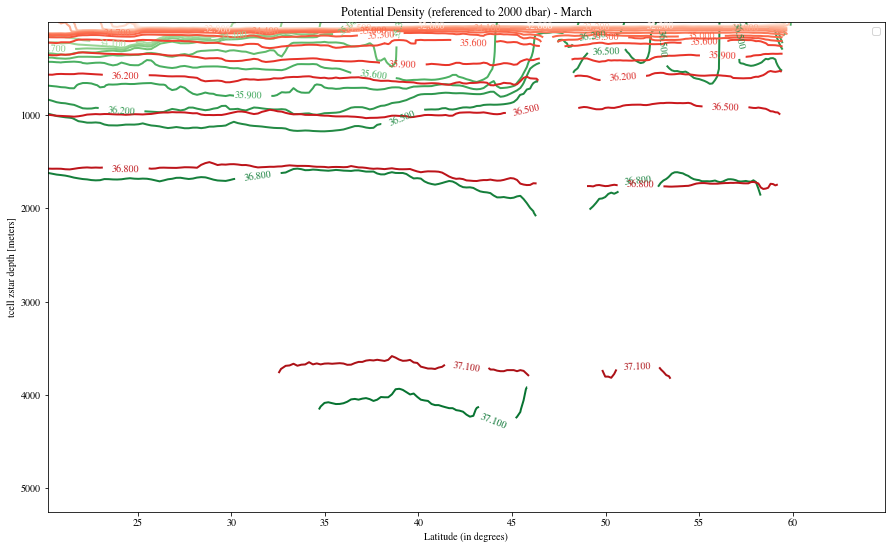

In [63]:
plt.figure(figsize=(15,9))

test_1 = potrho_2_con_Mar.cplot.contour(levels = np.linspace(32,38,21),cmap = 'Greens')
plt.gca().invert_yaxis()
plt.clabel(test_1, inline=True,fontsize=10)

test_2 = potrho_2_buo_Mar.sel(xt_ocean = -45, method = 'nearest').plot.contour(levels = np.linspace(32,38,21),cmap = 'Reds')
plt.gca().invert_yaxis()
plt.clabel(test_2, inline=True,fontsize=10)

plt.xlabel('Latitude (in degrees)')
plt.legend([test_1,test_2],['Control Run','No-stress Run'])
plt.title('Potential Density (referenced to 2000 dbar) - March')

Text(0.5, 1.0, 'Ocean depth (referenced to 2000 dbar) - September')

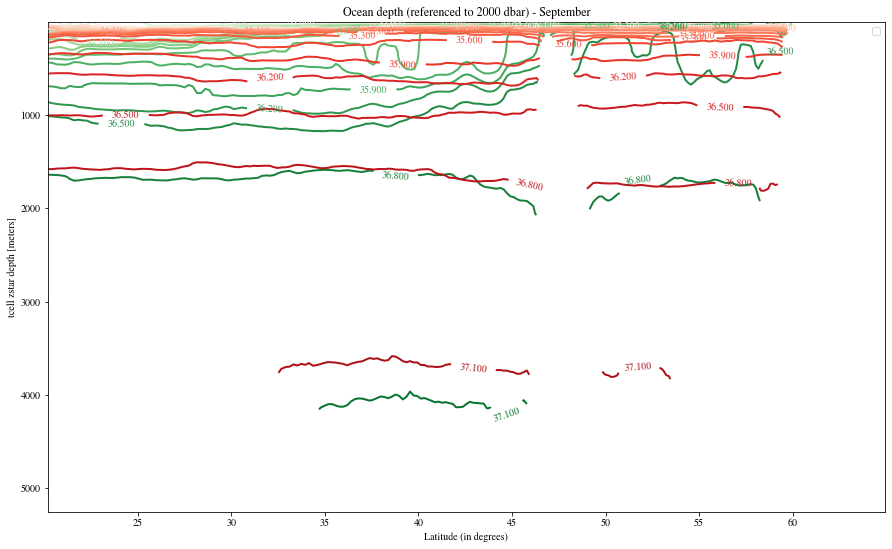

In [65]:
plt.figure(figsize=(15,9))

test_1 = potrho_2_con_Sep.sel(xt_ocean = -45, method = 'nearest').plot.contour(levels = np.linspace(32,38,21),cmap = 'Greens')
plt.gca().invert_yaxis()
plt.clabel(test_1, inline=True,fontsize=10)

test_2 = potrho_2_buo_Sep.sel(xt_ocean = -45, method = 'nearest').plot.contour(levels = np.linspace(32,38,21),cmap = 'Reds')
plt.gca().invert_yaxis()
plt.clabel(test_2, inline=True,fontsize=10)

plt.xlabel('Latitude (in degrees)')
plt.legend([test_1,test_2],['Control Run','No-stress Run'])
plt.title('Ocean depth (referenced to 2000 dbar) - September')

### 5. Zonal Velocity

In [72]:
u_con_NA = u_con.sel(xu_ocean = -45, method = 'nearest')
u_buo_NA = u_buo.sel(xu_ocean = -45, method = 'nearest')
v_con_NA = v_con.sel(xu_ocean = -45, method = 'nearest')
v_buo_NA = v_buo.sel(xu_ocean = -45, method = 'nearest')

In [73]:
start_time = '1950-01-01'
end_time = '1950-12-31'
u_con_Mar = u_con_NA.sel(time = slice('1950-03-01','1950-03-31')).mean('time')
u_buo_Mar = u_buo_NA.sel(time = slice('1950-03-01','1950-03-31')).mean('time')
u_con_Sep = u_con_NA.sel(time = slice('1950-09-01','1950-09-30')).mean('time')
u_buo_Sep = u_buo_NA.sel(time = slice('1950-09-01','1950-09-30')).mean('time')

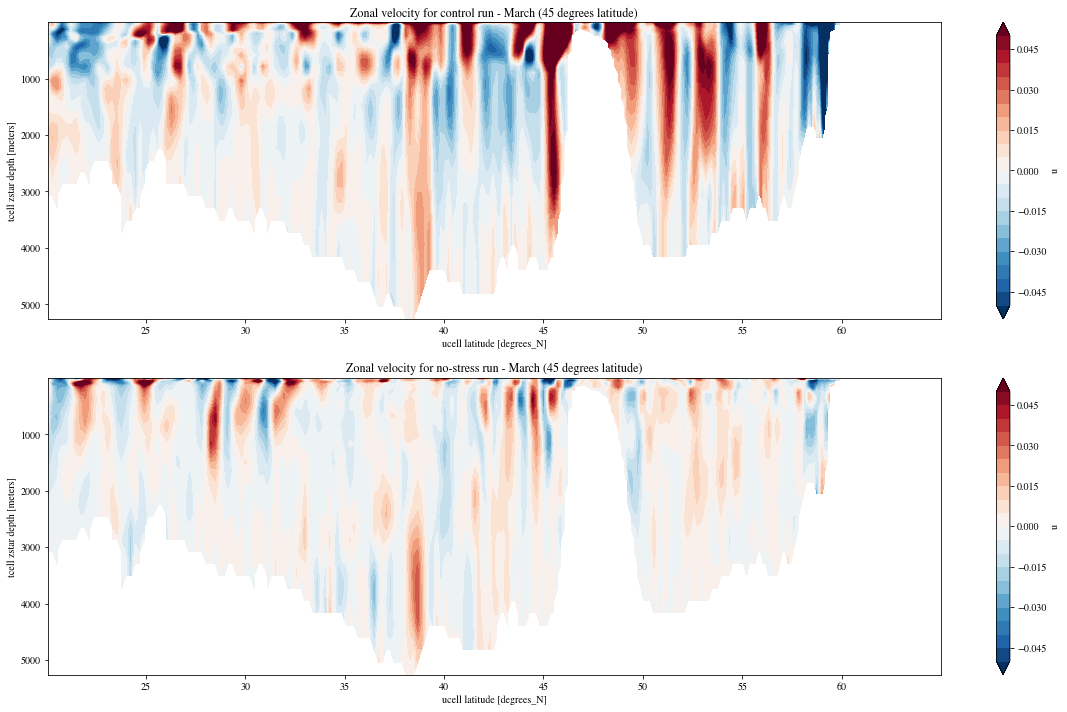

In [74]:
plt.figure(figsize=(20,12))
plt.subplot(211)
u_con_Mar.plot.contourf(levels = np.linspace(-0.05,0.05,21))
plt.gca().invert_yaxis()
plt.title('Zonal velocity for control run - March (45 degrees latitude)')

plt.subplot(212)
u_buo_Mar.plot.contourf(levels = np.linspace(-0.05,0.05,21))
plt.gca().invert_yaxis()
plt.title("Zonal velocity for no-stress run - March (45 degrees latitude)")

plt.show()

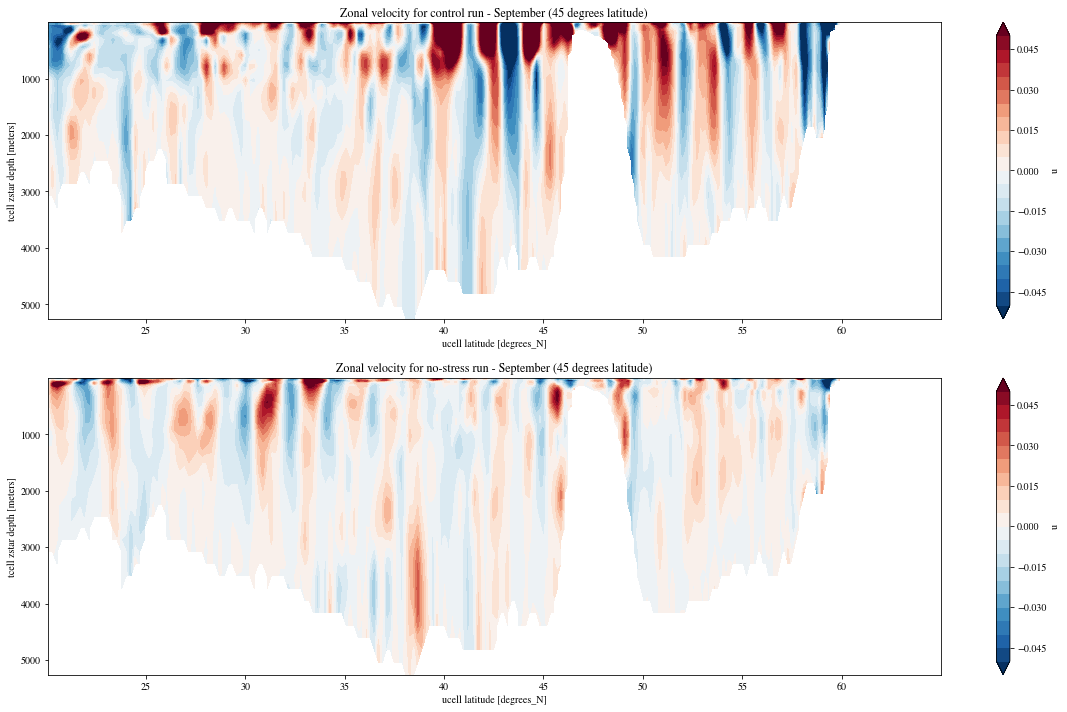

In [75]:
plt.figure(figsize=(20,12))
plt.subplot(211)
u_con_Sep.plot.contourf(levels = np.linspace(-0.05,0.05,21))
plt.gca().invert_yaxis()
plt.title('Zonal velocity for control run - September (45 degrees latitude)')

plt.subplot(212)
u_buo_Sep.plot.contourf(levels = np.linspace(-0.05,0.05,21))
plt.gca().invert_yaxis()
plt.title("Zonal velocity for no-stress run - September (45 degrees latitude)")

plt.show()

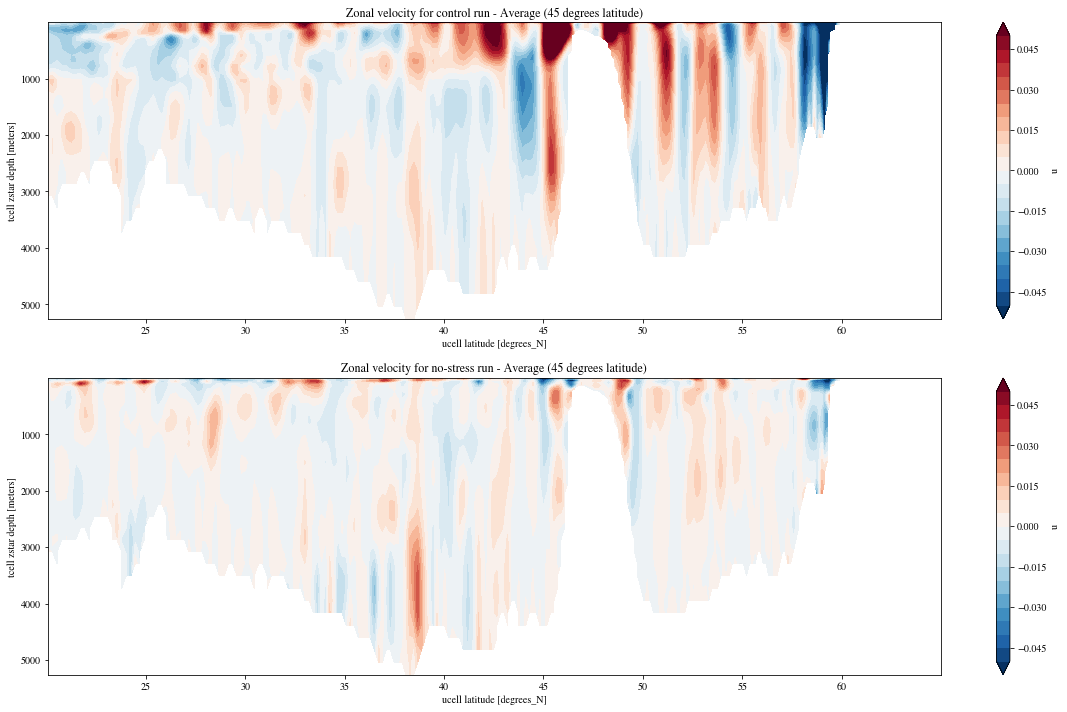

In [77]:
plt.figure(figsize=(20,12))
plt.subplot(211)
u_con_NA.sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(levels = np.linspace(-0.05,0.05,21))
plt.gca().invert_yaxis()
plt.title('Zonal velocity for control run - Time average (45 degrees latitude)')

plt.subplot(212)
u_buo_NA.sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(levels = np.linspace(-0.05,0.05,21))
plt.gca().invert_yaxis()
plt.title("Zonal velocity for no-stress run - Time average (45 degrees latitude)")

plt.show()

In [86]:
area_u = cc.querying.getvar(expt=expt[0], variable='area_u', session=session, frequency='static', n=1).sel(
    xu_ocean = slice(x_min,x_max)).sel(yu_ocean = slice(y_min,y_max))
u_avg_con = ((u_con_NA*area_u).sum(dim = ['xu_ocean'])/area_u.sum(dim = ['xu_ocean'])).where(abs(u_con_NA<=1.e1))
u_avg_buo = ((u_buo_NA*area_u).sum(dim = ['xu_ocean'])/area_u.sum(dim = ['xu_ocean'])).where(abs(u_con_NA<=1.e1))

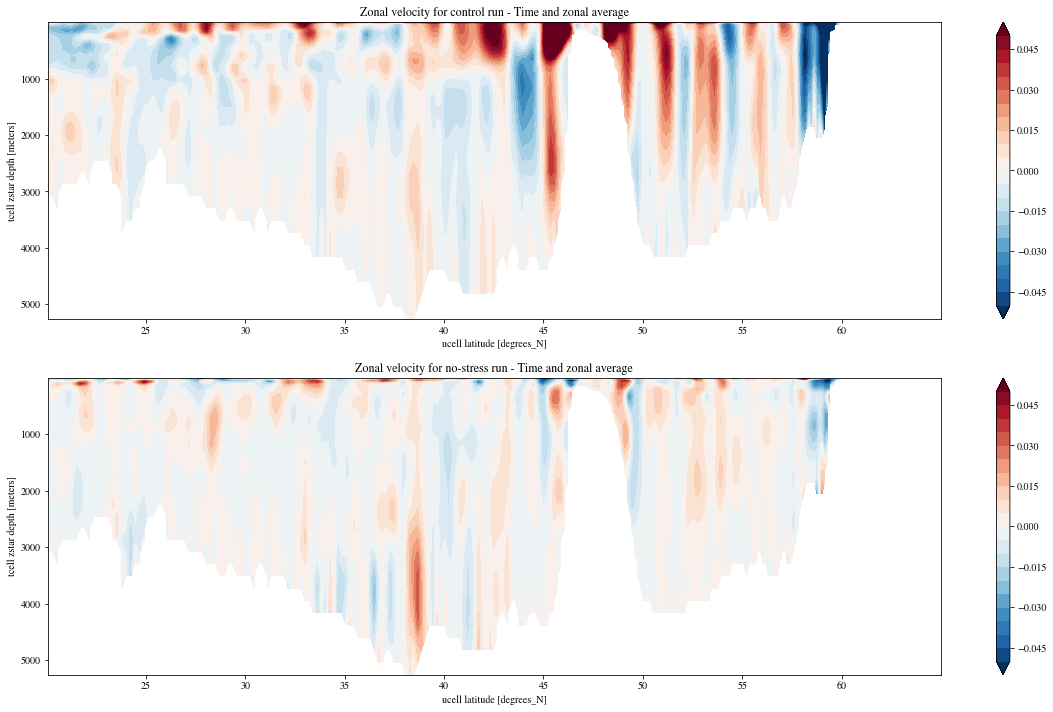

In [88]:
plt.figure(figsize=(20,12))
plt.subplot(211)
u_avg_con.sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(levels = np.linspace(-0.05,0.05,21))
plt.gca().invert_yaxis()
plt.title('Zonal velocity for control run - Time and zonal average')

plt.subplot(212)
u_avg_buo.sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(levels = np.linspace(-0.05,0.05,21))
plt.gca().invert_yaxis()
plt.title("Zonal velocity for no-stress run - Time and zonal average")

plt.show()